# Plotting pace data

source: Fitbit

In [27]:
import tcxparser 
import pandas as pd
import xmltodict as xml
import collections
from pint import UnitRegistry
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
# tcxparser tests 

tcx_file = "tcx_files/9785157455.tcx"
tcx_data = tcxparser.TCXParser(tcx_file)
print(tcx_data.activity_type)
print(tcx_data.completed_at)
print(tcx_data.duration)
print(tcx_data.distance)

# TCX parser doesn't return the distance?! 
# I don't get it...

running
2017-09-08T08:29:24.000-07:00
3573.0
0.0


In [87]:
from pint import UnitRegistry
import datetime
ureg = UnitRegistry()

def run_metrics(tcx_file):
    
    """Parses tcx_file. 
    Returns: start time of run and dictionary of lap, distance, and time."""
    
    with open(tcx_file) as tcx:
        try:
            tcx_obj = xml.parse(tcx.read())
            total_dist_m = 0
            total_time_sec = 0
            start_time = str(tcx_obj['TrainingCenterDatabase']['Activities']['Activity']['Lap'][0]['@StartTime'])
            lap_dict = collections.OrderedDict()
            laps = tcx_obj['TrainingCenterDatabase']['Activities']['Activity']['Lap']
            if laps:
                for n, lap in enumerate(laps):
                    lap_dict[n] = float(total_dist_m), float(total_time_sec)
                    total_dist_m+=float(lap['DistanceMeters'])
                    total_time_sec+=float(lap['TotalTimeSeconds'])
                return start_time, total_dist_m, total_time_sec
            else:
                return None
        except:
            print "Error! Unable to read file: ", tcx_file   

def track_lap_time(distance_in_meters, lap_type='speed', speed_1600m=(417, 427), tempo_1600m=(447, 457)):
    
    '''Returns time to finish distance_in_meters in minutes:seconds units.
    Default lap_type is speed. Specify "tempo" to return target tempo speed.'''
    
    distance_multiplier = float(distance_in_meters)/float(1600)
    
    def calc_target_time(seconds, dist_multiplier):
        target_time = (seconds * dist_multiplier)
        minutes = str(datetime.timedelta(seconds=target_time))
        return minutes
    
    if lap_type == 'speed':
        target = calc_target_time(417, distance_multiplier)
    elif lap_type == 'tempo':
        target = calc_target_time(447, distance_multiplier)
    return target

def sum_tcx(list_of_tcx_files):
    
    """Sums the total distance and total time contained with an input
    list of tcx_files. Returns start time of first tcx file."""
    total_dist = 0
    total_time = 0
    for ind, tcx in enumerate(list_of_tcx_files):
        if ind==0:
            start_time, dist, time = run_metrics(tcx)
        else:
            drop_start, dist, time = run_metrics(tcx)
        total_dist+=dist
        total_time+=time
    return start_time, total_dist, total_time

# Test function
start, dist_m, time_s = run_metrics('9785157455.tcx')

In [84]:
import numpy as np
print 'TIMES TO HIT'
print
distances = np.arange(400, 1800, 400)
lap_types = ['speed', 'tempo']
for lap_type in lap_types:
    print lap_type
    for dist in distances:
        target = track_lap_time(dist, lap_type=lap_type)
        print '%s: %s' %(tuple(map(str, [dist, target])))
    print

TIMES TO HIT

speed
400: 0:01:44.250000
800: 0:03:28.500000
1200: 0:05:12.750000
1600: 0:06:57

tempo
400: 0:01:51.750000
800: 0:03:43.500000
1200: 0:05:35.250000
1600: 0:07:27



In [86]:
os.chdir('tcx_files/')

OSError: [Errno 2] No such file or directory: 'tcx_files/'

In [55]:
# Parse files and create a df!

run_data_list = []
import os
for tcx_file in os.listdir('.'):
    tup = run_metrics(tcx_file)
    if tup:
        run_data_list.append(tup)

Error! Unable to read file:  .DS_Store
Error! Unable to read file:  8437947695.tcx
Error! Unable to read file:  9022871344.tcx
Error! Unable to read file:  pace.png


In [56]:
run_data = pd.DataFrame(run_data_list, columns = ['start', 'distance (m)', 'time (s)'])
run_data['start'] = pd.to_datetime(run_data['start'])

In [57]:
run_data.shape

(95, 3)

In [58]:
run_data.head()

,start,distance (m),time (s)
0,2016-12-31 15:12:00,26600.0,8691.0
1,2017-01-14 15:28:57,29190.0,9552.0
2,2017-01-17 12:59:23,11530.0,3901.0
3,2017-01-19 00:59:18,8170.0,2526.0
4,2017-01-19 19:16:12,10700.0,3262.0


In [59]:
from pint import UnitRegistry
ureg = UnitRegistry()

In [60]:
min_per_mi_list = []

for n, row in run_data.iterrows():
    dist = (row['distance (m)']) * ureg.meter
    miles = dist.to(ureg.mile)
    
    secs = (row['time (s)']) * ureg.seconds
    minutes = secs.to(ureg.minute)
    
    min_per_mile = (minutes/miles).magnitude
    tup = miles.magnitude, minutes.magnitude, min_per_mile
    min_per_mi_list.append(tup)

In [61]:
pace_df = pd.DataFrame(min_per_mi_list, columns = ['miles', 'minutes', 'min_per_mile'])
pace_df.head()

,miles,minutes,min_per_mile
0,16.528474,144.850000,8.763665
1,18.137825,159.200000,8.777238
2,7.164410,65.016667,9.074951
3,5.076603,42.100000,8.292948
4,6.648672,54.366667,8.177072


In [62]:
# Add pace and create a 'date' only column
run_data[pace_df.columns.tolist()] = pace_df[pace_df.columns.tolist()]
datetime_index_df = pd.DatetimeIndex(run_data['start']).normalize()
run_data['date'] = datetime_index_df.strftime('%D')

# Drop outliers that are likely tracking errors
ind_to_drop = run_data.loc[run_data['min_per_mile'] < 6.5].index.tolist()
run_data.drop(ind_to_drop, inplace=True)
run_data.head()

,start,distance (m),time (s),miles,minutes,min_per_mile,date
0,2016-12-31 15:12:00,26600.0,8691.0,16.528474,144.850000,8.763665,12/31/16
1,2017-01-14 15:28:57,29190.0,9552.0,18.137825,159.200000,8.777238,01/14/17
2,2017-01-17 12:59:23,11530.0,3901.0,7.164410,65.016667,9.074951,01/17/17
3,2017-01-19 00:59:18,8170.0,2526.0,5.076603,42.100000,8.292948,01/19/17
4,2017-01-19 19:16:12,10700.0,3262.0,6.648672,54.366667,8.177072,01/19/17


In [63]:
mean_pace = run_data['min_per_mile'].mean()

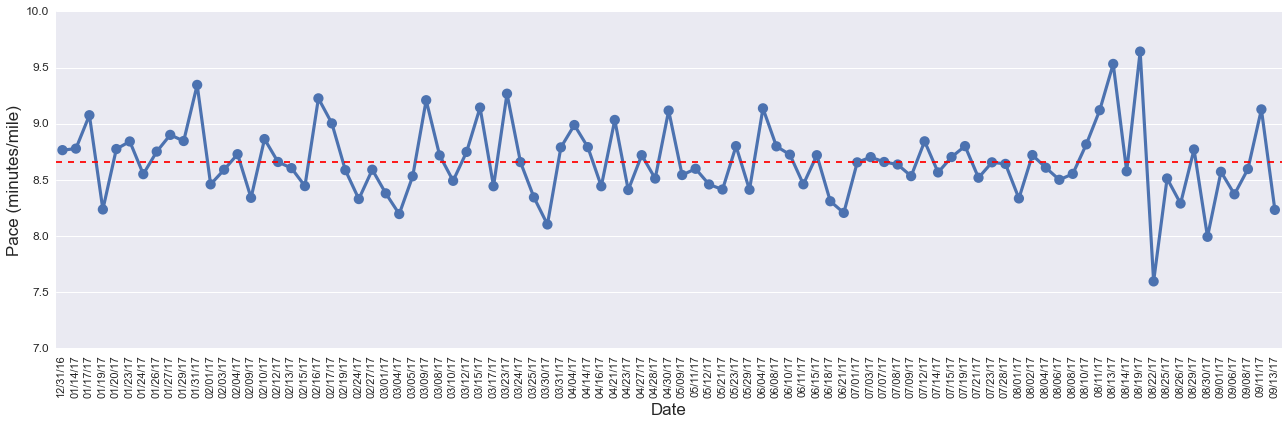

In [64]:
# Plot!
%matplotlib inline 
plt.rcParams['figure.figsize'] = (18, 6)
# plot this shameful data
sns.pointplot(x = run_data['date'], y = run_data['min_per_mile'], ci=None)
plt.axhline(y=mean_pace, color='r', linestyle='--')
plt.xticks(size = 11, rotation='vertical')
plt.ylim(7, 10)
plt.yticks(size=12)
plt.ylabel("Pace (minutes/mile)", size=17)
plt.xlabel("Date", size=17)
plt.tight_layout()
plt.savefig("pace.png")

In [94]:
# Weekly mileage
weekly = run_data[['start', 'miles', 'min_per_mile']].groupby(pd.Grouper(key='start', freq='W')).agg({'miles':[sum, 'mean', 'count'],  
                                                                                                    'min_per_mile': ['mean', 'min', 'max']})
weekly

miles                  min_per_mile                    
                  sum       mean count         mean       min       max
start                                                                  
2017-01-01  16.528474  16.528474     1     8.763665  8.763665  8.763665
2017-01-08        NaN        NaN     0          NaN       NaN       NaN
2017-01-15  18.137825  18.137825     1     8.777238  8.777238  8.777238
2017-01-22  24.301827   6.075457     4     8.579613  8.177072  9.074951
2017-01-29  44.800863   8.960173     5     8.777227  8.549640  8.899729
2017-02-05  39.873389   7.974678     5     8.741906  8.458751  9.344962
2017-02-12  26.060308   8.686769     3     8.619713  8.338627  8.862217
2017-02-19  40.743309   8.148662     5     8.771862  8.443177  9.225136
2017-02-26   7.114700   7.114700     1     8.327828  8.327828  8.327828
2017-03-05  41.358467  10.339617     4     8.423212  8.194206  8.589248
2017-03-12  33.696960   8.424240     4     8.790852  8.490305  9.208546
2017-03-19  14.086485   7.043242     2     8.792542  8.441851  9.143233
2017-03-26  29.384644   9.794881     3     8.755371  8.342619  9.266581
2017-04-02  12.303150   6.151575     2     8.444797  8.101314  8.788280
2017-04-09   4.890191   4.890191     1     8.987379  8.987379  8.987379
2017-04-16  26.035453  13.017726     2     8.616095  8.441823  8.790367
2017-04-23  17.591018   8.795509     2     8.720462  8.408300  9.032624
2017-04-30  36.132735  12.044245     3     8.781811  8.510364  9.116217
2017-05-07        NaN        NaN     0          NaN       NaN       NaN
2017-05-14  14.154836   4.718279     3     8.532491  8.457921  8.597650
2017-05-21   9.426201   9.426201     1     8.412721  8.412721  8.412721
2017-05-28   5.579913   5.579913     1     8.799420  8.799420  8.799420
2017-06-04  17.920345   8.960173     2     8.773466  8.410750  9.136181
2017-06-11  22.120814   7.373605     3     8.660039  8.459114  8.797456
2017-06-18  15.944385   7.972192     2     8.513400  8.308312  8.718488
2017-06-25   5.387288   5.387288     1     8.204499  8.204499  8.204499
2017-07-02   5.318937   5.318937     1     8.654611  8.654611  8.654611
2017-07-09  28.073550   7.018388     4     8.631716  8.531824  8.701459
2017-07-16  24.544162   8.181387     3     8.703148  8.564960  8.842240
2017-07-23  24.600086   8.200029     3     8.657367  8.517619  8.799587
2017-07-30   5.356220   5.356220     1     8.641045  8.641045  8.641045
2017-08-06  28.645212   7.161303     4     8.539859  8.333284  8.719616
2017-08-13  24.743001   6.185750     4     9.004616  8.552173  9.531815
2017-08-20  10.289907   5.144953     2     9.108516  8.574742  9.642289
2017-08-27  24.308041   6.077010     4     8.226035  7.593949  8.838362
2017-09-03  15.615058   5.205019     3     8.444023  7.991302  8.769931
2017-09-10  12.290722   6.145361     2     8.482576  8.369956  8.595196
2017-09-17  11.079048   5.539524     2     8.678968  8.231200  9.126737

In [66]:
mean_pace

8.65458006897715

In [54]:
run_data[['min_per_mile', 'distance (m)', 'miles']].describe()

,min_per_mile,distance (m),miles
count,91.000000,92.000000,91.000000
mean,8.651762,12723.586957,7.916815
std,0.323647,7213.899371,4.506152
min,7.593949,4680.000000,2.908017
25%,8.458336,8560.000000,5.318937
50%,8.635504,10965.000000,6.779160
75%,8.793912,11612.500000,7.260722
max,9.642289,42610.000000,26.476627
